# 이미지 분류를 위한 ViT(Vision Transformer) 모델 구현 실습

- 참고문헌: [관련 GitHub](https://github.com/keras-team/keras-io/blob/master/examples/vision/image_classification_with_vision_transformer.py)  
<br>  
- [ViT(Vision Transformer)](https://arxiv.org/abs/2010.11929) 모델을 구현해보았습니다. 이미지 분류를 위해 CIFAR-100 데이터 세트에서 시현했습니다. ViT 모델은 컨볼루션 레이어를 사용하지 않고 이미지 패치 시퀀스에 자가 주의를 갖는 Transformer 아키텍처를 적용합니다.

## 구현에 필요한 초기 세팅

- 최신 버전의 [TensorFlow Addons](https://www.tensorflow.org/addons/overview?hl=ko)를 설치 해줍니다. ↓

In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 24.1 MB/s 


- tensorflow를 사용하기 위해, 필요한 라이브러리를 import 해줍니다. ↓

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

## 데이터 준비

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169017344/169001437 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## 초매개변수(hyperparameters) 구성하기

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # 입력 이미지의 크기를 이 size로 조정합니다.
patch_size = 6  # 입력 이미지에서 추출할 패치의 size
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # transformer 레이어들의 크기
transformer_layers = 8
mlp_head_units = [2048, 1024]  # 최종 분류기의 조밀한 레이어 크기

## 데이터 증강 사용

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# 정규화를 위해 훈련 데이터의 평균과 분산을 계산합니다.
data_augmentation.layers[0].adapt(x_train)

## 다층 퍼셉트론(MLP) 구현

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## 레이어로 패치 생성 구현

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

## 샘플 이미지에 대한 패치 표시해보기

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


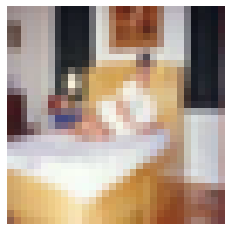

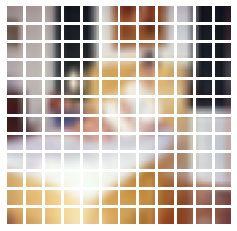

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## 패치 인코딩 계층 구현

`PatchEncoder`레이어는 패치를 `projection_dim` 크기의 벡터에 투영하여 선형으로 패치를 변환합니다.  
또한, 투영된 벡터에 학습 가능한 위치 임베딩을 추가합니다.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## ViT 모델 구축하기

ViT 모델은 `layers.MultiHeadAttention` 레이어를 패치 시퀀스에 적용되는 self-attention 메커니즘으로 사용하는 여러 개의 Transformer 블록으로 구성됩니다. Transformer 블록은 `[batch_size, num_patches, projection_dim]` 텐서를 생성하며, 이는 softmax가 있는 분류기 헤드를 통해 처리되어 최종 클래스 확률 출력을 생성합니다.  
<br>
이미지 표현으로 사용하기 위해 인코딩된 패치 시퀀스에 학습 가능한 임베딩을 추가하는 [논문](https://arxiv.org/abs/2010.11929)에서 설명된 기술과 달리, 최종 Transformer 블록의 모든 출력은 `layers.Flatten()`으로 재구성되고 분류기 헤드에 대한 이미지 표현 입력으로 사용됩니다. `layers.GlobalAveragePooling1D` 레어어는 특히 패치의 수와 투영 차원이 큰 경우, Transformer 블록의 출력을 집계하는 데 사용할 수도 있습니다.

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # 데이터 보강
    augmented = data_augmentation(inputs)
    # 패치 생성
    patches = Patches(patch_size)(augmented)
    # 인코딩 패치
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer 블록의 여러 레이어들을 만듭니다.
    for _ in range(transformer_layers):
        # Layer normalization(정규화) 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # multi-head attention layer 생성.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization(정규화) 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # [batch_size, projection_dim] tensor 생성.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # MLP 추가
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # 출력 분류
    logits = layers.Dense(num_classes)(features)
    # Keras 모델을 생성합니다.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## 모드 컴파일, 훈련 및 평가

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
176/176 [==============================] - 80s 381ms/step - loss: 4.4562 - accuracy: 0.0497 - top-5-accuracy: 0.1707 - val_loss: 3.8850 - val_accuracy: 0.1146 - val_top-5-accuracy: 0.3248
Epoch 2/100
176/176 [==============================] - 68s 384ms/step - loss: 3.9026 - accuracy: 0.1017 - top-5-accuracy: 0.3040 - val_loss: 3.5233 - val_accuracy: 0.1670 - val_top-5-accuracy: 0.4270
Epoch 3/100
176/176 [==============================] - 71s 403ms/step - loss: 3.6631 - accuracy: 0.1381 - top-5-accuracy: 0.3806 - val_loss: 3.3009 - val_accuracy: 0.2052 - val_top-5-accuracy: 0.4826
Epoch 4/100
176/176 [==============================] - 71s 401ms/step - loss: 3.4642 - accuracy: 0.1704 - top-5-accuracy: 0.4348 - val_loss: 3.2084 - val_accuracy: 0.2294 - val_top-5-accuracy: 0.5050
Epoch 5/100
176/176 [==============================] - 71s 402ms/step - loss: 3.3173 - accuracy: 0.1947 - top-5-accuracy: 0.4763 - val_loss: 3.0046 - val_accuracy: 0.2610 - val_top-5-accuracy: 0.5610


100 apochs 후에, ViT 모델은 테스트 데이터에서 약 56%의 정확도와 82%의 상위 5개의 정확도를 달성하는 것을 확인할 수 있었습니다.  